In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import warnings

import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    fbeta_score,
    f1_score,
    make_scorer,
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


from xgboost import XGBClassifier

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [4]:
feat_30_loc = "../data/features_30_sec.csv"
feat_3_loc = "../data/features_3_sec.csv"

<IPython.core.display.Javascript object>

In [5]:
# named long and short to differentiate easier
long = pd.read_csv(feat_30_loc)
short = pd.read_csv(feat_3_loc)

<IPython.core.display.Javascript object>

In [6]:
short.columns[short.columns.str.contains("_var")]

Index(['chroma_stft_var', 'rms_var', 'spectral_centroid_var',
       'spectral_bandwidth_var', 'rolloff_var', 'zero_crossing_rate_var',
       'harmony_var', 'perceptr_var', 'mfcc1_var', 'mfcc2_var', 'mfcc3_var',
       'mfcc4_var', 'mfcc5_var', 'mfcc6_var', 'mfcc7_var', 'mfcc8_var',
       'mfcc9_var', 'mfcc10_var', 'mfcc11_var', 'mfcc12_var', 'mfcc13_var',
       'mfcc14_var', 'mfcc15_var', 'mfcc16_var', 'mfcc17_var', 'mfcc18_var',
       'mfcc19_var', 'mfcc20_var'],
      dtype='object')

<IPython.core.display.Javascript object>

In [7]:
# log transform the mfcc variance
var_cols = short.columns[short.columns.str.contains("_var")]
logged_var_df = short.copy()
for col in var_cols:
    logged_var_df[col + "_logged"] = np.log(logged_var_df[col])
    logged_var_df = logged_var_df.drop(col, 1)

<IPython.core.display.Javascript object>

In [8]:
m_start = 12  # highest mfcc to use. higher than this is too high in the frequency spectrum to really matter
mel_freq_drops = [f"mfcc{x}_mean" for x in range(m_start, 21)] + [
    f"mfcc{x}_var_logged" for x in range(m_start, 21)
]

<IPython.core.display.Javascript object>

In [32]:
# best balance for VIF I could tune
drop_cols = [
    "length",
    "filename",
    "label",
    "zero_crossing_rate_mean",
    #     "zero_crossing_rate_var_logged",
    "rolloff_mean",
    "harmony_var_logged",
    "rolloff_var_logged",
    "spectral_centroid_var_logged",
    # "spectral_bandwidth_var_logged",
    "spectral_centroid_mean",
    "spectral_bandwidth_mean",
    #     "rms_mean",
    "rms_var_logged",
    "mfcc1_mean",
]
drop_cols = drop_cols + mel_freq_drops
print_vif(logged_var_df.drop(drop_cols, 1,))

VIF results
-------------------------------
const                            1717.734518
chroma_stft_mean                    3.468658
rms_mean                            3.369382
harmony_mean                        1.480543
perceptr_mean                       1.568489
tempo                               1.004005
mfcc2_mean                          3.681449
mfcc3_mean                          2.014336
mfcc4_mean                          2.018802
mfcc5_mean                          2.658583
mfcc6_mean                          3.300665
mfcc7_mean                          3.009415
mfcc8_mean                          3.677661
mfcc9_mean                          2.596669
mfcc10_mean                         2.579487
mfcc11_mean                         2.090299
chroma_stft_var_logged              2.283900
spectral_bandwidth_var_logged       3.581251
zero_crossing_rate_var_logged       4.345614
perceptr_var_logged                 5.229151
mfcc1_var_logged                    2.737436
mfcc2_var_l

<IPython.core.display.Javascript object>

In [33]:
X = logged_var_df.drop(drop_cols, 1,)
y = logged_var_df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=34, stratify=y
)

<IPython.core.display.Javascript object>

In [34]:
num_cols = list(X.columns)

bin_cols = []

cat_cols = []
drop_cats = []


preprocessing = ColumnTransformer(
    [
        # Scale numeric columns (not needed for all models but can't hurt)
        ("scaler", StandardScaler(), num_cols)
    ],
    remainder="passthrough",
)


pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        # Choose your model and put it here
        ("xgb", XGBClassifier()),
    ]
)


params = {
    "xgb__subsample": [0.5, 0.75, 1.0],
    "xgb__colsample_bytree": [0.4, 0.6, 0.8, 1.0],
    "xgb__max_depth": [6, 8, 10],
}

n_trees = 100
learning_rate = 10 / n_trees

pipeline["xgb"].n_estimators = n_trees
pipeline["xgb"].learning_rate = learning_rate

scaler = pipeline.named_steps["preprocessing"]
scaler.fit(X_train)
X_test_scaled = scaler.transform(X_test)


pipeline_cv = GridSearchCV(pipeline, params, verbose=1, n_jobs=-1, cv=2)

pipeline_cv.fit(X_train, y=y_train, xgb__eval_set=[(X_test_scaled, y_test)])


print(pipeline_cv.score(X_train, y_train))
print(pipeline_cv.score(X_test, y_test))
pipeline_cv.best_params_

Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  1.1min


[0]	validation_0-merror:0.38288
[1]	validation_0-merror:0.29229


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  2.6min finished


[2]	validation_0-merror:0.27077
[3]	validation_0-merror:0.24274
[4]	validation_0-merror:0.23624
[5]	validation_0-merror:0.22473
[6]	validation_0-merror:0.21572
[7]	validation_0-merror:0.21421
[8]	validation_0-merror:0.21021
[9]	validation_0-merror:0.19920
[10]	validation_0-merror:0.19520
[11]	validation_0-merror:0.19069
[12]	validation_0-merror:0.18919
[13]	validation_0-merror:0.18569
[14]	validation_0-merror:0.18018
[15]	validation_0-merror:0.17868
[16]	validation_0-merror:0.17267
[17]	validation_0-merror:0.17367
[18]	validation_0-merror:0.17017
[19]	validation_0-merror:0.17017
[20]	validation_0-merror:0.17367
[21]	validation_0-merror:0.16817
[22]	validation_0-merror:0.16416
[23]	validation_0-merror:0.16416
[24]	validation_0-merror:0.16517
[25]	validation_0-merror:0.16416
[26]	validation_0-merror:0.16266
[27]	validation_0-merror:0.15916
[28]	validation_0-merror:0.15766
[29]	validation_0-merror:0.15566
[30]	validation_0-merror:0.15415
[31]	validation_0-merror:0.15065
[32]	validation_0-

{'xgb__colsample_bytree': 0.6, 'xgb__max_depth': 10, 'xgb__subsample': 0.75}

<IPython.core.display.Javascript object>

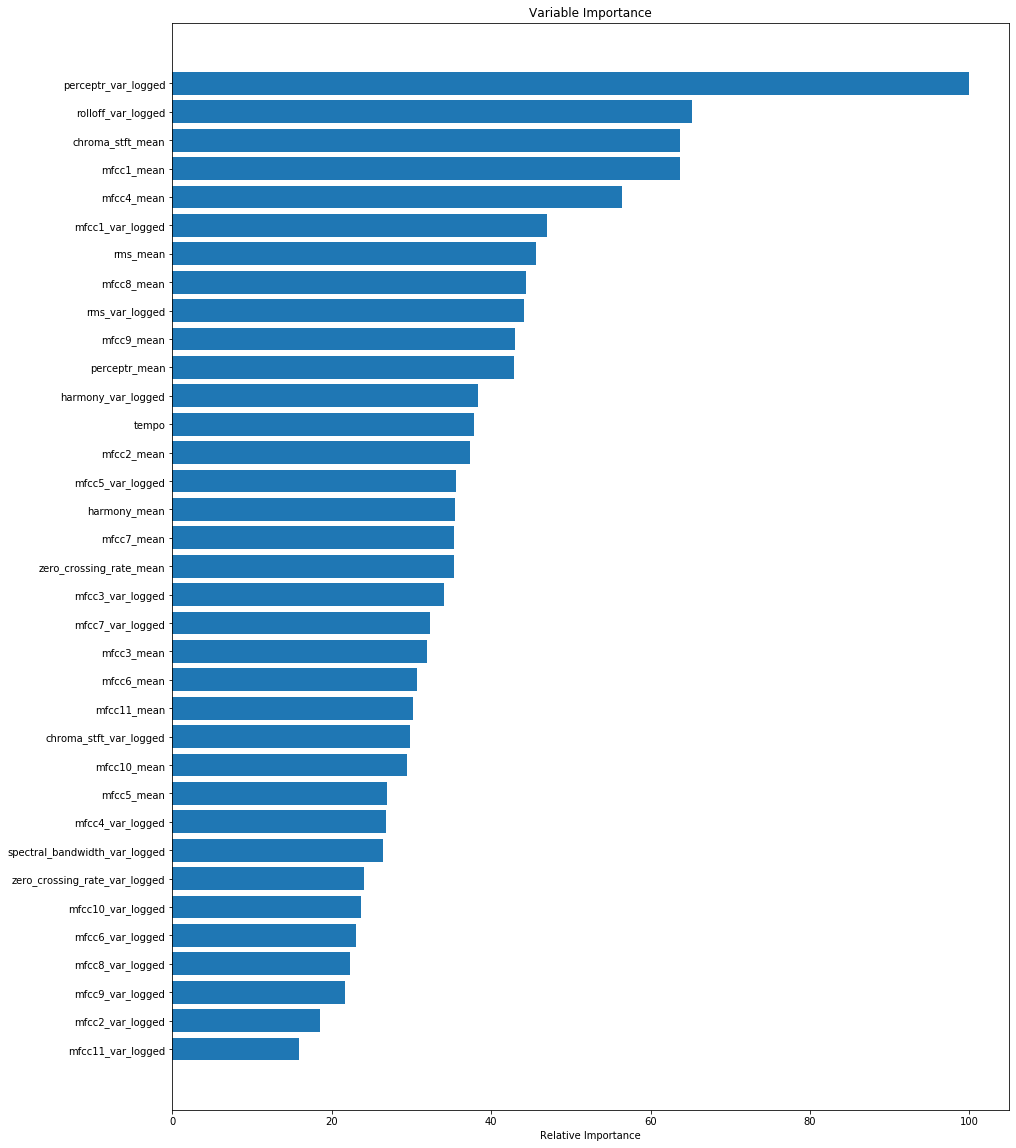

<IPython.core.display.Javascript object>

In [14]:
feature_importance = pipeline_cv.best_estimator_.named_steps["xgb"].feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5


plt.figure(figsize=(15, 20))
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

In [ ]:
y_pred = pipeline_cv.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
pipeline_cv.predict(X)

In [ ]:
short["predicted"] = pipeline_cv.predict(X)

In [ ]:
short.head()

In [ ]:
long["vote_pred"] = "none"

for i in range(long["filename"].size):
    curr_file = long["filename"][i]
    file_stripped = curr_file.strip(".wav")
    sub_selection = short["filename"].str.contains(file_stripped)
    prediction = (
        short[sub_selection]["predicted"]
        .value_counts()
        .sort_values(ascending=False)
        .index[0]
    )
    long["vote_pred"][i] = prediction

In [ ]:
long.head()

In [ ]:


print(confusion_matrix(long["label"], long["vote_pred"]))
print(classification_report(long["label"], long["vote_pred"]))

In [15]:
n = 6
top_n = list(X.columns[sorted_idx][-n:])

<IPython.core.display.Javascript object>

In [17]:
print_vif(logged_var_df[top_n])

VIF results
-------------------------------
const                  523.187992
mfcc1_var_logged         2.576321
mfcc4_mean               1.164393
mfcc1_mean               9.110961
chroma_stft_mean         1.663606
rolloff_var_logged       1.784841
perceptr_var_logged      9.266466
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

In [19]:
X = logged_var_df[top_n]
y = logged_var_df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=34, stratify=y
)

<IPython.core.display.Javascript object>

In [20]:
num_cols = list(X.columns)

bin_cols = []

cat_cols = []
drop_cats = []


preprocessing = ColumnTransformer(
    [
        # Scale numeric columns (not needed for all models but can't hurt)
        ("scaler", StandardScaler(), num_cols)
    ],
    remainder="passthrough",
)


pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        # Choose your model and put it here
        ("xgb", XGBClassifier()),
    ]
)


params = {
    "xgb__subsample": [0.5, 0.75, 1.0],
    "xgb__colsample_bytree": [0.4, 0.6, 0.8, 1.0],
    "xgb__max_depth": [6, 8, 10],
}

n_trees = 100
learning_rate = 10 / n_trees

pipeline["xgb"].n_estimators = n_trees
pipeline["xgb"].learning_rate = learning_rate

scaler = pipeline.named_steps["preprocessing"]
scaler.fit(X_train)
X_test_scaled = scaler.transform(X_test)


pipeline_cv = GridSearchCV(pipeline, params, verbose=1, n_jobs=-1, cv=2)

pipeline_cv.fit(X_train, y=y_train, xgb__eval_set=[(X_test_scaled, y_test)])


print(pipeline_cv.score(X_train, y_train))
print(pipeline_cv.score(X_test, y_test))
pipeline_cv.best_params_

Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   27.7s


[0]	validation_0-merror:0.47798
[1]	validation_0-merror:0.44795
[2]	validation_0-merror:0.43093
[3]	validation_0-merror:0.42893


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   58.4s finished


[4]	validation_0-merror:0.42192
[5]	validation_0-merror:0.41241
[6]	validation_0-merror:0.41642
[7]	validation_0-merror:0.40841
[8]	validation_0-merror:0.40791
[9]	validation_0-merror:0.40591
[10]	validation_0-merror:0.40691
[11]	validation_0-merror:0.40440
[12]	validation_0-merror:0.40741
[13]	validation_0-merror:0.40340
[14]	validation_0-merror:0.40140
[15]	validation_0-merror:0.39740
[16]	validation_0-merror:0.39489
[17]	validation_0-merror:0.39640
[18]	validation_0-merror:0.39139
[19]	validation_0-merror:0.39089
[20]	validation_0-merror:0.38589
[21]	validation_0-merror:0.38538
[22]	validation_0-merror:0.38338
[23]	validation_0-merror:0.38438
[24]	validation_0-merror:0.38388
[25]	validation_0-merror:0.38488
[26]	validation_0-merror:0.38488
[27]	validation_0-merror:0.38338
[28]	validation_0-merror:0.38338
[29]	validation_0-merror:0.37988
[30]	validation_0-merror:0.38138
[31]	validation_0-merror:0.37638
[32]	validation_0-merror:0.37738
[33]	validation_0-merror:0.37738
[34]	validation_

{'xgb__colsample_bytree': 1.0, 'xgb__max_depth': 10, 'xgb__subsample': 0.5}

<IPython.core.display.Javascript object>

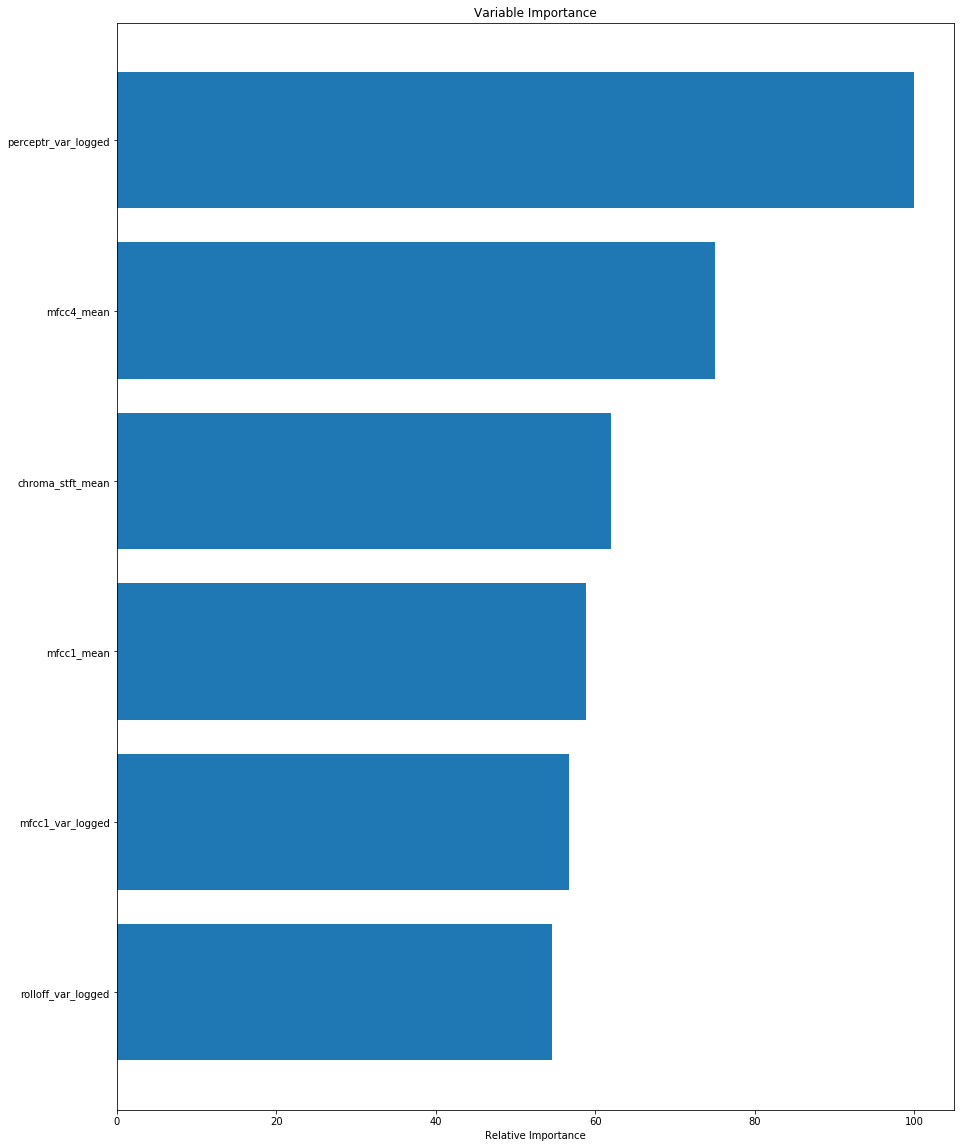

<IPython.core.display.Javascript object>

In [21]:
feature_importance = pipeline_cv.best_estimator_.named_steps["xgb"].feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5


plt.figure(figsize=(15, 20))
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

In [22]:
y_pred = pipeline_cv.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[140   1  16   4   5  12   6   1   8   7]
 [  1 182   1   0   0  14   1   1   0   0]
 [ 23   2  98   8   1  29   0   1  15  22]
 [  8   1  18  97  18   5   3  19  12  19]
 [  6   0   5  13 138   1   4  17  15   1]
 [ 12  19  18   3   0 140   0   0   2   6]
 [  7   0   3   0   6   5 160   0   2  17]
 [  5   1  11  12   8   7   0 137  12   7]
 [  6   0  16  14  14  10   1   6 125   8]
 [  8   3  27  22   4   9  11   3  20  92]]
              precision    recall  f1-score   support

       blues       0.65      0.70      0.67       200
   classical       0.87      0.91      0.89       200
     country       0.46      0.49      0.48       199
       disco       0.56      0.48      0.52       200
      hiphop       0.71      0.69      0.70       200
        jazz       0.60      0.70      0.65       200
       metal       0.86      0.80      0.83       200
         pop       0.74      0.69      0.71       200
      reggae       0.59      0.62      0.61       200
        rock       0.51     

<IPython.core.display.Javascript object>

In [23]:
short["label"].unique()[0]

'blues'

<IPython.core.display.Javascript object>

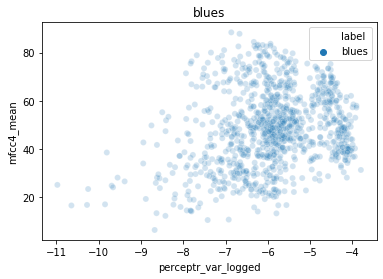

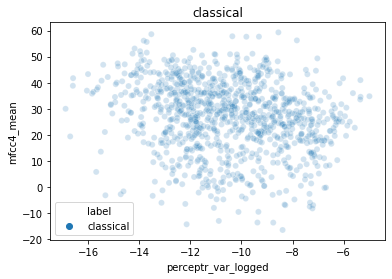

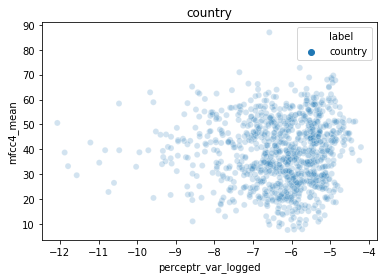

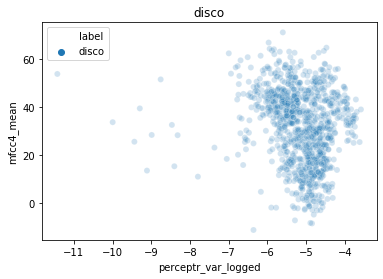

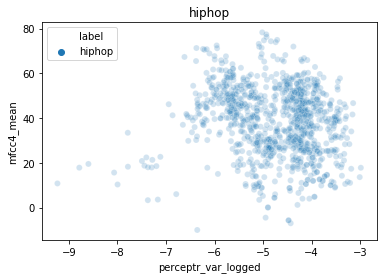

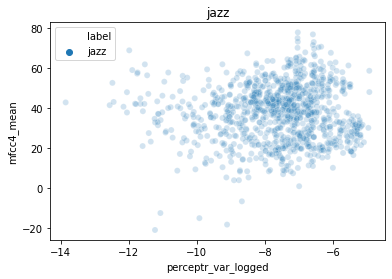

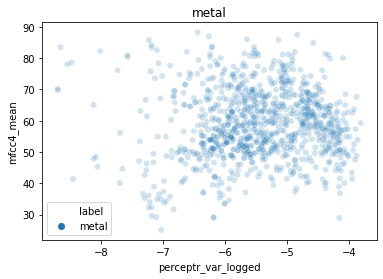

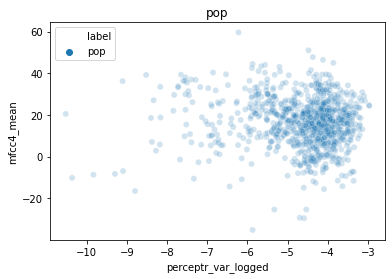

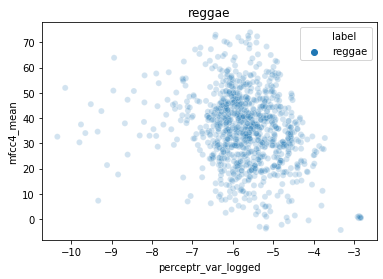

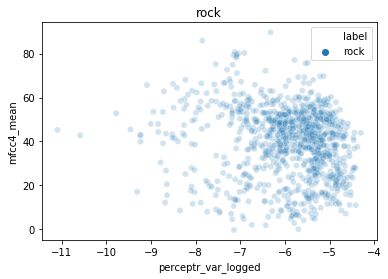

<IPython.core.display.Javascript object>

In [26]:
for genre in short["label"].unique():

    sns.scatterplot(
        "perceptr_var_logged",
        "mfcc4_mean",
        hue="label",
        data=logged_var_df[logged_var_df["label"] == genre],
        alpha=0.2,
    )
    plt.title(genre)
    plt.show()

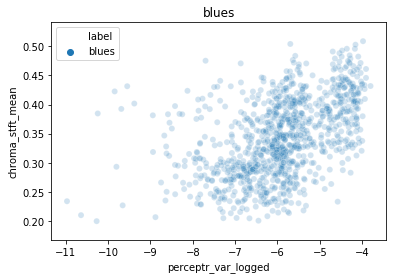

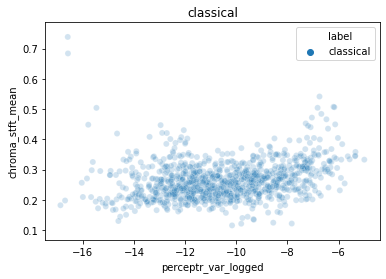

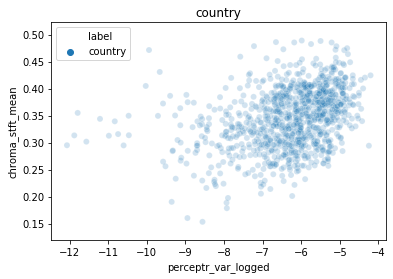

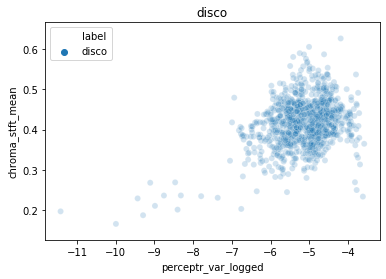

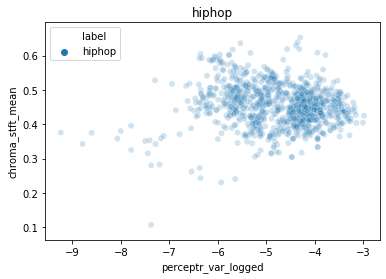

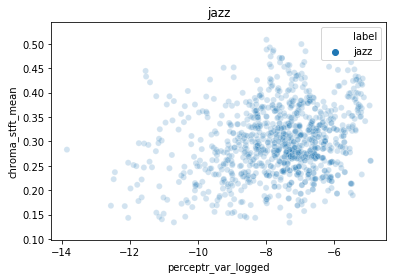

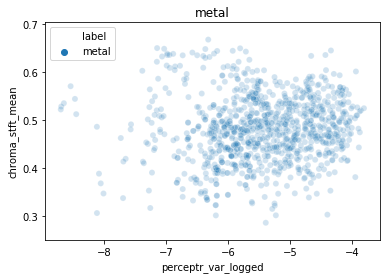

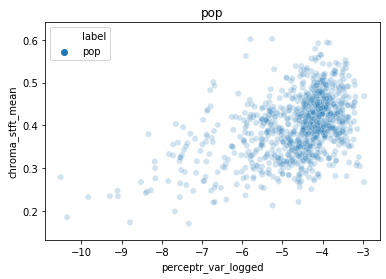

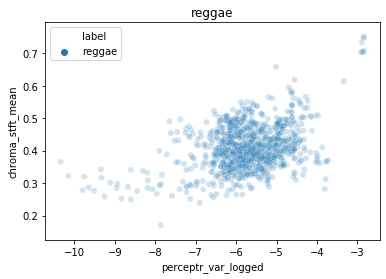

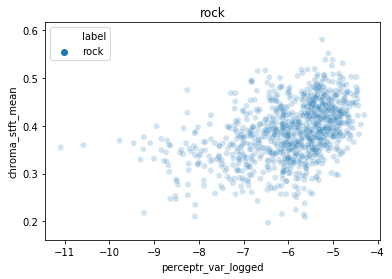

<IPython.core.display.Javascript object>

In [27]:
for genre in short["label"].unique():

    sns.scatterplot(
        "perceptr_var_logged",
        "chroma_stft_mean",
        hue="label",
        data=logged_var_df[logged_var_df["label"] == genre],
        alpha=0.2,
    )
    plt.title(genre)
    plt.show()